# Plan

* organizar preprocesamiento
 * corregir fecha TRM
* Dejar Solo funciones
* programar ciclos
* dejar registro quiebras
* dejar registro cuantos quiebran y sobreviven
* analizar resultados en otro script
 * hurst
 * ley potencia
* probar con nuevo resultado
* probar con otro indice
* fin


# Librerías y configuraciones generales

In [1]:
import pandas as pd
from random import randrange
import random
import math
from statsmodels.tsa.api import SimpleExpSmoothing
import matplotlib.pyplot as plt
import warnings

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Preprocesamiento 
* Carga datos de entrada

In [4]:
rango_lectura=['2020-10-09','2021-05-18']
rango_indice=['2020-09-09','2021-05-18']

In [5]:
base_rss = pd.read_csv (r'TranformacionBases_Java/Rss_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')
base_twitter = pd.read_csv (r'TranformacionBases_Java/Twitter_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [6]:
# rangos datos lecturas
print("rango rss: min: ",min(base_rss['date_adj']), " max: ",max(base_rss['date_adj']))
print("rango twitter: min: ",min(base_twitter['date']), " max: ",max(base_twitter['date']))

rango rss: min:  2020-10-09  max:  2021-05-18
rango twitter: min:  2020-10-05  max:  2021-05-30


In [7]:
datos_twitter=base_twitter[['id_fuente','date','polaridad']].groupby(['id_fuente','date']).mean().reset_index()
#datos_twitter

In [8]:
datos_twitter['date'] = pd.to_datetime(datos_twitter['date']).dt.date

In [9]:
datos_rss=base_rss[['fuenteRss','date','polaridad']].groupby(['fuenteRss','date']).mean().reset_index()
#datos_rss

In [10]:
datos_rss['date'] = pd.to_datetime(datos_rss['date']).dt.date

### Eliminar dias sin lecturas

In [11]:
## empezar desde el 9 de octubre

In [12]:
val_twitter=datos_twitter[['date','id_fuente']].groupby('date').count()

In [13]:
#val_twitter[val_twitter['id_fuente']<val_twitter['id_fuente'].mean()-(val_twitter['id_fuente'].std())*1.64]

In [14]:
val_rss=datos_rss[['date','fuenteRss']].groupby('date').count()
#val_rss

In [15]:
#val_rss[val_rss['fuenteRss']<val_rss['fuenteRss'].mean()-(val_rss['fuenteRss'].std())*1.7]

In [16]:
## fin validacion rss

In [17]:
fechas_quitar=list(val_twitter[val_twitter['id_fuente']<val_twitter['id_fuente'].mean()-(val_twitter['id_fuente'].std())*1.64].index)

In [18]:
fechas_quitar=fechas_quitar+list(val_rss[val_rss['fuenteRss']<val_rss['fuenteRss'].mean()-(val_rss['fuenteRss'].std())*1.7].index)

In [19]:
fechas_quitar

[datetime.date(2020, 10, 5),
 datetime.date(2020, 10, 6),
 datetime.date(2020, 10, 7),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2021, 1, 9),
 datetime.date(2021, 3, 19),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 5, 21),
 datetime.date(2020, 10, 13),
 datetime.date(2020, 10, 14),
 datetime.date(2020, 10, 15),
 datetime.date(2020, 10, 16),
 datetime.date(2020, 10, 17),
 datetime.date(2020, 10, 18),
 datetime.date(2020, 10, 19),
 datetime.date(2020, 10, 20),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2020, 12, 10),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1)]

In [20]:
## eliminar duplicados

In [21]:
fechas_quitar = list(dict.fromkeys(fechas_quitar))

In [22]:
##igualar rangos

In [23]:
datos_trm=pd.read_csv (r'TranformacionBases_Java/TRM_total_adap_multi.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [24]:
datos_trm=datos_trm[datos_trm['date']>=rango_indice[0]]
datos_trm=datos_trm[datos_trm['date']<=rango_indice[1]]

In [25]:
datos_trm

,Fecha,fecha operación,TRM,Diferencia,Dia sem,nom Dia Sem,fin Semana,Dif Cero,date_operacion,date
10514,9/9/2020,8/9/2020,3757.21,54.59,3,mar,0,0,2020-09-08,2020-09-09
10515,10/9/2020,9/9/2020,3717.25,-39.96,4,mié,0,0,2020-09-09,2020-09-10
10516,11/9/2020,10/9/2020,3700.28,-16.97,5,jue,0,0,2020-09-10,2020-09-11
10517,12/9/2020,11/9/2020,3709.00,8.72,6,vie,0,0,2020-09-11,2020-09-12
10518,13/9/2020,12/9/2020,3709.00,0.00,7,sáb,1,1,2020-09-12,2020-09-13
...,...,...,...,...,...,...,...,...,...,...
10761,14/5/2021,13/5/2021,3728.09,-6.00,5,jue,0,0,2021-05-13,2021-05-14
10762,15/5/2021,14/5/2021,3682.84,-45.25,6,vie,0,0,2021-05-14,2021-05-15
10763,16/5/2021,15/5/2021,3682.84,0.00,7,sáb,1,1,2021-05-15,2021-05-16
10764,17/5/2021,16/5/2021,3682.84,0.00,1,dom,1,1,2021-05-16,2021-05-17


In [26]:
datos_trm['date'] = pd.to_datetime(datos_trm['date']).dt.date

In [27]:
datos_twitter.columns=['fuente','date','polaridad']
datos_rss.columns=['fuente','date','polaridad']

In [28]:
#datos_rss

In [29]:
datos_lectura=datos_twitter.append(datos_rss)

In [30]:
#datos_lectura

In [31]:
pd.to_datetime(rango_lectura[0]).date()

datetime.date(2020, 10, 9)

In [32]:
#datos_lectura=datos_lectura[datos_lectura['date']>=rango_lectura[0]]
#datos_lectura=datos_lectura[datos_lectura['date']<=rango_lectura[1]]
datos_lectura=datos_lectura[datos_lectura['date']>=pd.to_datetime(rango_lectura[0]).date()]
datos_lectura=datos_lectura[datos_lectura['date']<=pd.to_datetime(rango_lectura[1]).date()]

In [33]:
datos_lectura=datos_lectura[datos_lectura['polaridad']!=0]

In [34]:
datos_lectura

,fuente,date,polaridad
0,BluRadioCo,2020-10-09,-0.347026
1,BluRadioCo,2020-10-10,-0.271511
2,BluRadioCo,2020-10-11,-0.635847
3,BluRadioCo,2020-10-25,-0.249044
4,BluRadioCo,2020-10-26,-0.410109
...,...,...,...
109898,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400
109899,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484
109900,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641
109901,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855


## Carga Maestro Fuentes

In [35]:
base_maestro_fuentes = pd.read_csv (r'TranformacionBases_Java/maestro_fuentes.csv', engine='python', encoding = "ISO-8859-1", sep=';')

In [36]:
base_maestro_fuentes.reset_index()

,index,fuente,tipo
0,0,http://elnacional.com.do/feed/,rss
1,1,http://ep00.epimg.net/rss/economia/portada.xml,rss
2,2,http://ep00.epimg.net/rss/tags/ultimas_noticia...,rss
3,3,http://feeds.nytimes.com/nyt/rss/Business,rss
4,4,http://feeds.nytimes.com/nyt/rss/Technology,rss
...,...,...,...
132,132,elcolombiano,twitter
133,133,elespectador,twitter
134,134,lafm,twitter
135,135,rcnmundo,twitter


In [37]:
datos_lectura=datos_lectura.merge(base_maestro_fuentes.reset_index(), left_on='fuente', right_on='fuente', how='left')
datos_lectura

,fuente,date,polaridad,index,tipo
0,BluRadioCo,2020-10-09,-0.347026,118,twitter
1,BluRadioCo,2020-10-10,-0.271511,118,twitter
2,BluRadioCo,2020-10-11,-0.635847,118,twitter
3,BluRadioCo,2020-10-25,-0.249044,118,twitter
4,BluRadioCo,2020-10-26,-0.410109,118,twitter
...,...,...,...,...,...
78606,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400,117,rss
78607,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484,117,rss
78608,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641,117,rss
78609,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855,117,rss


In [38]:
datos_lectura

,fuente,date,polaridad,index,tipo
0,BluRadioCo,2020-10-09,-0.347026,118,twitter
1,BluRadioCo,2020-10-10,-0.271511,118,twitter
2,BluRadioCo,2020-10-11,-0.635847,118,twitter
3,BluRadioCo,2020-10-25,-0.249044,118,twitter
4,BluRadioCo,2020-10-26,-0.410109,118,twitter
...,...,...,...,...,...
78606,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400,117,rss
78607,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484,117,rss
78608,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641,117,rss
78609,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855,117,rss


## Calendario

In [39]:
calendario = pd.DataFrame({"Date": pd.date_range(rango_indice[0], rango_indice[1])})

In [40]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
247,2021-05-14
248,2021-05-15
249,2021-05-16
250,2021-05-17


In [41]:
### remover dias seleccionados
fechas_quitar

[datetime.date(2020, 10, 5),
 datetime.date(2020, 10, 6),
 datetime.date(2020, 10, 7),
 datetime.date(2020, 10, 8),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 10, 22),
 datetime.date(2020, 10, 23),
 datetime.date(2020, 10, 24),
 datetime.date(2021, 1, 9),
 datetime.date(2021, 3, 19),
 datetime.date(2021, 4, 28),
 datetime.date(2021, 5, 21),
 datetime.date(2020, 10, 13),
 datetime.date(2020, 10, 14),
 datetime.date(2020, 10, 15),
 datetime.date(2020, 10, 16),
 datetime.date(2020, 10, 17),
 datetime.date(2020, 10, 18),
 datetime.date(2020, 10, 19),
 datetime.date(2020, 10, 20),
 datetime.date(2020, 12, 10),
 datetime.date(2021, 5, 18),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1)]

In [42]:
calendario=calendario[~calendario['Date'].isin(fechas_quitar)]

In [43]:
calendario=calendario.reset_index(drop=True)

In [44]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
226,2021-05-13
227,2021-05-14
228,2021-05-15
229,2021-05-16


In [45]:
calendario['Date']=pd.to_datetime(calendario['Date']).dt.date

# Agente

In [46]:
def crearAgente(id,tipo): #quizas falta el valor del var econ,
    agente={}
    agente['TIPO']=tipo
    agente['id']=id
    agente['edad']=0
    agente['capital']= randrange(1000,1000000000)
    agente['stockProducto']=randrange(10,1000000)
    agente['umbralStock']=randrange(10,1000000)
    agente['habilidadAdministrativa']=random.uniform(-0.02, 0.5)
    #agente['tasaConsumo']=random.uniform(0.1, 0.5)
    if agente['TIPO']=='Comprador':
        agente['rentabilidad']=random.uniform(0.1, 0.2)
    elif agente['TIPO']=='Vendedor':
        agente['rentabilidad']=random.uniform(0.2, 0.6)
    agente['tamanoRegresion']= randrange(5,20)
    # perfilIntereses  No aplica
    agente['impactoTextos']=random.uniform(-1, 1)
    agente['estrategiaLectura']=[0]*NUM_FUENTES_INTERPRETACION
    agente['estrategiaLectura_imp']=[0]*NUM_FUENTES_INTERPRETACION
    for i in range(NUM_FUENTES_INTERPRETACION):
        agente['estrategiaLectura'][i]=randrange(NUM_FUENTES_TOTATALES)
        agente['estrategiaLectura_imp'][i]=random.random()
    agente['numeroDiasLecturas']=randrange(2,7)
    agente['umbralPronostico']=random.uniform(0.2, 0.5)
    agente['porcentajeCapitalCompra']=random.uniform(0, 1)
    agente['porcentajeStockVenta']=random.uniform(0, 1)
    #agente['costoMauc']  costo del commoditie según bolsa
    #agente['costosFijos']=random.uniform(0.1, 0.3)
    agente['tasaProduccion']=random.uniform(0, 0.5)
    #agente['limiteSobrePrecio']=random.uniform(0.01, 0.3)
    agente['viveza']=random.uniform(0.005, 0.02)
    agente['controlGastosEImpuestos']=random.uniform(0.1, 0.3)
    return agente

In [47]:
def pronosticoAgente(agente):    
    reg_inicio=FECHA_PULSO-agente['tamanoRegresion']
    rango_reg_agente=[calendario.iloc[reg_inicio]['Date'],calendario.iloc[FECHA_PULSO]['Date']]

    serie_indice_agente=datos_trm[datos_trm['date']>=rango_reg_agente[0]]
    serie_indice_agente=serie_indice_agente[serie_indice_agente['date']<=rango_reg_agente[1]]

    modelo_agente=SimpleExpSmoothing(serie_indice_agente['TRM']).fit(smoothing_level=0.5,optimized=False)
    prediccion_base_agente=modelo_agente.forecast()

    prediccion_base_agente=prediccion_base_agente.values[0]
    df_lecura_agente=pd.DataFrame({'index':agente['estrategiaLectura'] , 'impacto': agente['estrategiaLectura_imp']})

    lect_inicio=FECHA_PULSO-agente['numeroDiasLecturas']
    rango_lec_agente=[calendario.iloc[lect_inicio]['Date'],calendario.iloc[FECHA_PULSO]['Date']]

    serie_lectura_agente=datos_lectura[datos_lectura['date']>=rango_lec_agente[0]]
    serie_lectura_agente=serie_lectura_agente[serie_lectura_agente['date']<=rango_lec_agente[1]]
    serie_lectura_agente=serie_lectura_agente.merge(df_lecura_agente, left_on='index', right_on='index', how='left')

    serie_lectura_agente=serie_lectura_agente[serie_lectura_agente['impacto'].notnull()]
    serie_lectura_agente['factor']=serie_lectura_agente['polaridad']*serie_lectura_agente['impacto']
    
    #agente['pronosticos_dia_siguiente']=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
    if len(serie_lectura_agente)>0 :
        #agente['pronosticos_dia_siguiente']=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
        pronosticos_dia_siguiente=prediccion_base_agente*(1+serie_lectura_agente['factor'].mean()*agente['impactoTextos'])
    else:
        #agente['pronosticos_dia_siguiente']=prediccion_base_agente
        pronosticos_dia_siguiente=prediccion_base_agente
        
    return pronosticos_dia_siguiente

In [48]:
def activacionComprador(agente):
    #cuando
    agente['activo']=False
    #necesita stock?
    val_stock=agente['stockProducto']<agente['umbralStock']
    #el cambio del mercado le combiene?  prediccion - valor actual
    val_conveniencia=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE) > agente['umbralPronostico']
    #alguna de las 2 situaciones
    agente['activo']=val_stock or val_conveniencia
    #cuanto comprar
    agente['cantidadTransaccionar']=agente['capital']*agente['porcentajeCapitalCompra']/VALOR_MOMENTO_INDICE ## revisar
    #precio negociacion
    agente['precioNegociacion']=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(1-agente['viveza'])+VALOR_MOMENTO_INDICE
    return agente['activo']

In [49]:
def activacionVendedor(agente):
    #cuando vender
    agente['activo']=False
    #necesita stock?
    val_stock=agente['stockProducto']>agente['umbralStock']
    #el cambio del mercado le combiene?  prediccion - valor actual
    val_conveniencia=(VALOR_MOMENTO_INDICE - agente['pronosticos_dia_siguiente'] ) > agente['umbralPronostico']
    #alguna de las 2 situaciones
    agente['activo']=val_stock or val_conveniencia
    #cuanto vender
    agente['cantidadTransaccionar']=agente['stockProducto']*agente['porcentajeStockVenta']
    #precio negociacion
    agente['precioNegociacion']=(agente['pronosticos_dia_siguiente'] - VALOR_MOMENTO_INDICE)*(1+agente['viveza'])+VALOR_MOMENTO_INDICE
    return agente['activo']

In [50]:
def transaccionarAgente(agenteComprador,agenteVendedor):
    #id agentes
    idComprador=agenteComprador.get('id')
    idVendedor=agenteVendedor.get('id')    
    #definir cantidad transaccionar
    cantidadRequeridaComprador=agenteComprador['cantidadTransaccionar']
    cantidadDisponibleVendedor=agenteVendedor['cantidadTransaccionar']
    cantidadTransaccion= cantidadRequeridaComprador if cantidadRequeridaComprador<cantidadDisponibleVendedor else cantidadDisponibleVendedor
    #precio transaccion
    precioTransaccion=agenteVendedor['precioNegociacion']
    #numeroPulsoActual
    #FECHA_PULSO
    
    #Cambio estado agentes
    #comprador
    agenteComprador['capital']=agenteComprador['capital']-precioTransaccion*cantidadTransaccion
    ##sin costo mauc
    agenteComprador['stockProducto']=agenteComprador['stockProducto']+cantidadTransaccion
    agenteComprador['cantidadTransaccionar']=agenteComprador['cantidadTransaccionar']-cantidadTransaccion
    #vendedor
    agenteVendedor['capital']=agenteVendedor['capital']+precioTransaccion*cantidadTransaccion
    agenteVendedor['stockProducto']=agenteVendedor['stockProducto']-cantidadTransaccion
    agenteVendedor['cantidadTransaccionar']=agenteVendedor['cantidadTransaccionar']-cantidadTransaccion
    #validar activacion agentes, retornar para acciones
    desactivarComprador=agenteComprador['cantidadTransaccionar']==0
    desactivarVendedor=agenteVendedor['cantidadTransaccionar']==0
    lineaTransaccion=[idComprador,idVendedor,cantidadTransaccion,precioTransaccion,FECHA_PULSO]
    #return {'desact_comp':desactivarComprador, 'desact_vend':desactivarVendedor, 'lineaTransaccion':lineaTransaccion}
    return [desactivarComprador, desactivarVendedor, lineaTransaccion]

In [51]:
def vivirComprador(agente):
    #aprovecha unidades
    unidadesAprovechadas=agente['habilidadAdministrativa']*agente['stockProducto']
    agente['stockProducto']=agente['stockProducto']-unidadesAprovechadas
    #tiene gastos
    agente['capital']=agente['capital']*(1-agente['controlGastosEImpuestos'])
    #recibe capital
    precioAprovechamiento=VALOR_MOMENTO_INDICE/(1-agente['rentabilidad'])
    agente['capital']=agente['capital']+unidadesAprovechadas*precioAprovechamiento
    #reevaluar costos fijos 
    #aumentar edad
    agente['edad']=agente['edad']+1

In [52]:
def vivirVendedor(agente):
    #tiene gastos
    agente['capital']=agente['capital']*(1-agente['controlGastosEImpuestos'])
    #le cuesta producir
    agente['capital']=agente['capital']*(1-agente['habilidadAdministrativa'])*agente['tasaProduccion']
    #aumenta el stock con lo producido
    agente['stockProducto']=agente['stockProducto']+agente['stockProducto']*agente['tasaProduccion']
    #aumenta edad
    agente['edad']=agente['edad']+1

# Universo

In [53]:
#GENERACION ESPONTANEA UNIVERSO
def generacionEspontanea():     
    global NUMERO_ACUMULADO_AGENTES
    for i in range(POBLACION_INICIAL):
        NUMERO_ACUMULADO_AGENTES=NUMERO_ACUMULADO_AGENTES+1
        if(random.random()<=CANT_COMPRADORES):            
            compradores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Comprador'))
        else:
            vendedores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Vendedor'))

In [54]:
def quiebraEmpresas():
    #quiebraEmpresas    
    for comp in compradores:
        capiltalEmpresa=comp['capital']
        valorStockEmpresa=comp['stockProducto']*VALOR_MOMENTO_INDICE
        valorEmpresa=capiltalEmpresa+valorStockEmpresa        
        #print("COMP capemp:",capiltalEmpresa,' valemp:',valorEmpresa, ' limQuiebra:',LIMITE_QUIEBRA)
        if capiltalEmpresa<LIMITE_QUIEBRA or valorEmpresa<LIMITE_QUIEBRA :
            #print("entraComp")
            compradores.remove(comp)     
            agentesQuebrados.append(comp)
    for vend in vendedores:
        capiltalEmpresa=vend['capital']
        valorStockEmpresa=vend['stockProducto']*VALOR_MOMENTO_INDICE
        valorEmpresa=capiltalEmpresa+valorStockEmpresa        
        #print("VEND capemp:",capiltalEmpresa,' valemp:',valorEmpresa, ' limQuiebra:',LIMITE_QUIEBRA)
        if capiltalEmpresa<LIMITE_QUIEBRA or valorEmpresa<LIMITE_QUIEBRA :
            #print("entraVend")
            vendedores.remove(vend)
            agentesQuebrados.append(vend)

In [55]:
def nuevosAgentes():
    global NUMERO_ACUMULADO_AGENTES
    #num_nuevos_agentes=math.floor(random.uniform(0, MAX_GENERACION_AGENTES)*POBLACION_ACTUAL)
    num_nuevos_agentes=math.floor(random.uniform(0, MAX_GENERACION_AGENTES)*POBLACION_ACTUAL)
    print("max_generacion_agentes: ",MAX_GENERACION_AGENTES,"nuevos Agentes: ", num_nuevos_agentes, "pob actual: ",POBLACION_ACTUAL, "pob final: ",POBLACION_ACTUAL+num_nuevos_agentes)
    for i in range(POBLACION_ACTUAL,POBLACION_ACTUAL+num_nuevos_agentes):
        NUMERO_ACUMULADO_AGENTES=NUMERO_ACUMULADO_AGENTES+1
        if(random.random()<=CANT_COMPRADORES):
            compradores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Comprador'))
        else:
            vendedores.append(crearAgente(NUMERO_ACUMULADO_AGENTES,'Vendedor'))

In [56]:
def pronosticoUniverso():
    for comp in compradores:
        #print(pronosticoAgente(comp))
        comp['pronosticos_dia_siguiente']=pronosticoAgente(comp)
    for vend in vendedores:
        #print(pronosticoAgente(vend))
        vend['pronosticos_dia_siguiente']=pronosticoAgente(vend)

In [57]:
def activacionUniverso():
    for comp in compradores:
        #print(pronosticoAgente(comp))
        auxActivacion=activacionComprador(comp)
        if auxActivacion:
            compradoresActivos.append(comp)
    for vend in vendedores:
        #print(pronosticoAgente(vend))
        auxActivacion=activacionVendedor(vend)
        if auxActivacion:
            vendedoresActivos.append(vend)

In [58]:
### Función transaccionar
def transaccionarUniverso():
    random.shuffle(compradoresActivos)
    
    for comp in compradoresActivos:     
        if len(vendedoresActivos)==0:
            #print("no hay vendedores")
            break

        df_ofertas=pd.DataFrame.from_dict(vendedoresActivos).sort_values('precioNegociacion')
        mejorVendedor=next(item for item in vendedoresActivos if item['id'] == df_ofertas.iloc[0]['id'])
        compradorMomento=comp

        precioMaximoCompra=compradorMomento['precioNegociacion']
        precioMinimoVenta=mejorVendedor['precioNegociacion']
        #selecciona si puede transaccionar
        if precioMaximoCompra>precioMinimoVenta:
            #print("transaccionar")
            #puede desactivar algun vendedor, antes de pasar a las siguientes transacciones
            (desactivarComprador, desactivarVendedor, lineaTransaccion)=transaccionarAgente(compradorMomento,mejorVendedor)
            #agregar transaccion a arreglo de transacciones con datos principales
            if desactivarComprador:
                compradoresActivos.remove(compradorMomento)
            if desactivarVendedor:
                vendedoresActivos.remove(mejorVendedor) 
            #registra la transacción
            DF_TRANSACCIONES.loc[len(DF_TRANSACCIONES)]=lineaTransaccion

In [59]:
def vivirUniverso():
    for comp in compradores:
        vivirComprador(comp)
    for vend in vendedores:
        vivirVendedor(vend)

# SIMULACION

## Parametros Globales

In [60]:
#AGENTES
NUM_FUENTES_TOTATALES=137
NUM_FUENTES_INTERPRETACION=5

In [61]:
#UNIVERSO
POBLACION_INICIAL=1000
CANT_COMPRADORES=0.6

#LIMITE_QUIEBRA=1000
LIMITE_QUIEBRA=10000000
MAX_GENERACION_AGENTES=0.02

POBLACION_ACTUAL=0

In [62]:
FECHA_INICIAL_PULSO=36
FECHA_PULSO=FECHA_INICIAL_PULSO   #fecha inicial con información suficiente

In [63]:
NUMERO_ACUMULADO_AGENTES=0

In [64]:
#tipo_indice='real'
tipo_indice='emergente'

In [65]:
VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']

In [66]:
#VALOR_MOMENTO_INDICE

In [67]:
DF_TRANSACCIONES=pd.DataFrame(columns=['idComprador','idVendedor','cantidadTransaccion','precioTransaccion','fechaPulso']) ###llevar antes al algoritmo

In [68]:
compradores=[]
vendedores=[]

In [69]:
NUMERO_ACUMULADO_AGENTES

0

In [70]:
generacionEspontanea()

In [71]:
print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))

numCompradores:  599 numVendedores:  401


In [72]:
agentesQuebrados=[]

### ciclos simulacion

In [73]:
252-FECHA_PULSO

216

In [74]:
len(vendedores)

401

In [75]:
#pensar en agregar un número fijo de agentes

In [76]:
aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']*aux_df_agentC['capital']
aux_df_agentC['pulso']=FECHA_PULSO-1
aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']*aux_df_agentV['capital']
aux_df_agentV['pulso']=FECHA_PULSO-1
df_estadoAgentes=aux_df_agentC
df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)
df_estadoAgentes

,id,TIPO,edad,capital,stockProducto,val_stock,val_empresa,pulso
0,3,Comprador,0,187681460,466125,1.798571e+09,3.375585e+17,35
1,4,Comprador,0,475659857,770871,2.974452e+09,1.414827e+18,35
2,6,Comprador,0,386072173,669049,2.581566e+09,9.966707e+17,35
3,7,Comprador,0,117801787,264397,1.020192e+09,1.201804e+17,35
4,8,Comprador,0,909727978,881782,3.402409e+09,3.095266e+18,35
...,...,...,...,...,...,...,...,...
396,991,Vendedor,0,682776713,565293,2.181217e+09,1.489284e+18,35
397,992,Vendedor,0,612989236,515444,1.988872e+09,1.219157e+18,35
398,993,Vendedor,0,58973355,890898,3.437583e+09,2.027258e+17,35
399,998,Vendedor,0,339152541,582355,2.247052e+09,7.620933e+17,35


In [77]:
#df_estadoAgentes=pd.DataFrame.from_dict(compradores)
#df_estadoAgentes=df_estadoAgentes.append(pd.DataFrame.from_dict(vendedores))

In [78]:
#for generacion in range(0,100,1):
for generacion in range(0,len(calendario)-FECHA_INICIAL_PULSO,1):
    if tipo_indice=='real' or generacion==0:
        VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']
    elif tipo_indice=='emergente':
        aux_df_transacciones=DF_TRANSACCIONES[DF_TRANSACCIONES['fechaPulso']==FECHA_PULSO-1]
        aux_df_transacciones['importe']=aux_df_transacciones['cantidadTransaccion']*aux_df_transacciones['precioTransaccion']
        #aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        VALOR_MOMENTO_INDICE=aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        
    POBLACION_ACTUAL=len(compradores)+len(vendedores)    
    quiebraEmpresas()# capturar información de agentes quebrados
    POBLACION_ACTUAL=len(compradores)+len(vendedores)
    print("PULSO: ",FECHA_PULSO, "Generacion: ",generacion, " poblacion actual: ",POBLACION_ACTUAL,' numero acumulado agentes: ',NUMERO_ACUMULADO_AGENTES)
    nuevosAgentes()
    #print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))
    pronosticoUniverso()
    compradoresActivos=[]
    vendedoresActivos=[]
    activacionUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    transaccionarUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    vivirUniverso()
    print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores) )
    ## capturar estado empresas
    if len(compradores)>0:
        aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']+aux_df_agentC['capital']
        aux_df_agentC['pulso']=FECHA_PULSO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentC)
        
    if len(vendedores)>0:
        aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']+aux_df_agentV['capital']
        aux_df_agentV['pulso']=FECHA_PULSO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)
        
    FECHA_PULSO=FECHA_PULSO+1

PULSO:  36 Generacion:  0  poblacion actual:  990  numero acumulado agentes:  1000
max_generacion_agentes:  0.02 nuevos Agentes:  10 pob actual:  990 pob final:  1000
numCompradores:  600 numVendedores:  400
PULSO:  37 Generacion:  1  poblacion actual:  958  numero acumulado agentes:  1010
max_generacion_agentes:  0.02 nuevos Agentes:  6 pob actual:  958 pob final:  964
numCompradores:  602 numVendedores:  362
PULSO:  38 Generacion:  2  poblacion actual:  869  numero acumulado agentes:  1016
max_generacion_agentes:  0.02 nuevos Agentes:  16 pob actual:  869 pob final:  885
numCompradores:  608 numVendedores:  277
PULSO:  39 Generacion:  3  poblacion actual:  801  numero acumulado agentes:  1032
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  801 pob final:  801
numCompradores:  605 numVendedores:  196
PULSO:  40 Generacion:  4  poblacion actual:  742  numero acumulado agentes:  1032
max_generacion_agentes:  0.02 nuevos Agentes:  12 pob actual:  742 pob final:  754
numComp

numCompradores:  572 numVendedores:  14
PULSO:  76 Generacion:  40  poblacion actual:  578  numero acumulado agentes:  1221
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  578 pob final:  578
numCompradores:  567 numVendedores:  11
PULSO:  77 Generacion:  41  poblacion actual:  568  numero acumulado agentes:  1221
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  568 pob final:  572
numCompradores:  563 numVendedores:  9
PULSO:  78 Generacion:  42  poblacion actual:  560  numero acumulado agentes:  1225
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  560 pob final:  564
numCompradores:  556 numVendedores:  8
PULSO:  79 Generacion:  43  poblacion actual:  555  numero acumulado agentes:  1229
max_generacion_agentes:  0.02 nuevos Agentes:  1 pob actual:  555 pob final:  556
numCompradores:  550 numVendedores:  6
PULSO:  80 Generacion:  44  poblacion actual:  542  numero acumulado agentes:  1230
max_generacion_agentes:  0.02 nuevos Agentes:  2 pob ac

numCompradores:  419 numVendedores:  8
PULSO:  116 Generacion:  80  poblacion actual:  423  numero acumulado agentes:  1373
max_generacion_agentes:  0.02 nuevos Agentes:  6 pob actual:  423 pob final:  429
numCompradores:  420 numVendedores:  9
PULSO:  117 Generacion:  81  poblacion actual:  422  numero acumulado agentes:  1379
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  422 pob final:  422
numCompradores:  416 numVendedores:  6
PULSO:  118 Generacion:  82  poblacion actual:  417  numero acumulado agentes:  1379
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  417 pob final:  420
numCompradores:  415 numVendedores:  5
PULSO:  119 Generacion:  83  poblacion actual:  417  numero acumulado agentes:  1382
max_generacion_agentes:  0.02 nuevos Agentes:  6 pob actual:  417 pob final:  423
numCompradores:  417 numVendedores:  6
PULSO:  120 Generacion:  84  poblacion actual:  414  numero acumulado agentes:  1388
max_generacion_agentes:  0.02 nuevos Agentes:  2 pob

numCompradores:  377 numVendedores:  7
PULSO:  156 Generacion:  120  poblacion actual:  380  numero acumulado agentes:  1507
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  380 pob final:  380
numCompradores:  375 numVendedores:  5
PULSO:  157 Generacion:  121  poblacion actual:  376  numero acumulado agentes:  1507
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  376 pob final:  376
numCompradores:  373 numVendedores:  3
PULSO:  158 Generacion:  122  poblacion actual:  371  numero acumulado agentes:  1507
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  371 pob final:  371
numCompradores:  369 numVendedores:  2
PULSO:  159 Generacion:  123  poblacion actual:  366  numero acumulado agentes:  1507
max_generacion_agentes:  0.02 nuevos Agentes:  7 pob actual:  366 pob final:  373
numCompradores:  366 numVendedores:  7
PULSO:  160 Generacion:  124  poblacion actual:  370  numero acumulado agentes:  1514
max_generacion_agentes:  0.02 nuevos Agentes:  

numCompradores:  319 numVendedores:  4
PULSO:  196 Generacion:  160  poblacion actual:  317  numero acumulado agentes:  1600
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  317 pob final:  317
numCompradores:  314 numVendedores:  3
PULSO:  197 Generacion:  161  poblacion actual:  315  numero acumulado agentes:  1600
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  315 pob final:  318
numCompradores:  315 numVendedores:  3
PULSO:  198 Generacion:  162  poblacion actual:  304  numero acumulado agentes:  1603
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  304 pob final:  304
numCompradores:  301 numVendedores:  3
PULSO:  199 Generacion:  163  poblacion actual:  303  numero acumulado agentes:  1603
max_generacion_agentes:  0.02 nuevos Agentes:  1 pob actual:  303 pob final:  304
numCompradores:  301 numVendedores:  3
PULSO:  200 Generacion:  164  poblacion actual:  301  numero acumulado agentes:  1604
max_generacion_agentes:  0.02 nuevos Agentes:  

# Estado final transacciones

In [79]:
DF_TRANSACCIONES

,idComprador,idVendedor,cantidadTransaccion,precioTransaccion,fechaPulso
0,729.0,424.0,1.068653e+04,1967.799629,36.0
1,345.0,424.0,5.490700e+04,1967.799629,36.0
2,704.0,521.0,2.436028e+05,2223.624910,36.0
3,759.0,521.0,5.626588e+04,2223.624910,36.0
4,850.0,521.0,4.177709e+03,2223.624910,36.0
...,...,...,...,...,...
39427,1624.0,1231.0,1.044607e+04,3065.604153,230.0
39428,1125.0,1231.0,1.818478e+04,3065.604153,230.0
39429,72.0,1231.0,3.199704e+05,3065.604153,230.0
39430,1042.0,1231.0,6.749232e+05,3065.604153,230.0


In [80]:
#agentesQuebrados
pd.DataFrame.from_dict(agentesQuebrados).sort_values('edad')

,TIPO,id,edad,capital,stockProducto,umbralStock,habilidadAdministrativa,rentabilidad,tamanoRegresion,impactoTextos,estrategiaLectura,estrategiaLectura_imp,numeroDiasLecturas,umbralPronostico,porcentajeCapitalCompra,porcentajeStockVenta,tasaProduccion,viveza,controlGastosEImpuestos,pronosticos_dia_siguiente,activo,cantidadTransaccionar,precioNegociacion
0,Comprador,220,0,8.189052e+06,764915.000000,651599,0.380581,0.135698,13,-0.966946,"[79, 82, 31, 64, 27]","[0.8382871692436359, 0.8650224220564775, 0.440...",4,0.355405,0.399962,0.753083,0.065917,0.008811,0.249916,NaN,NaN,NaN,NaN
9,Vendedor,937,0,6.497320e+05,611418.000000,173760,0.078669,0.560364,5,0.745376,"[10, 105, 113, 15, 22]","[0.45110574689993743, 0.5900479448330048, 0.87...",5,0.417421,0.960242,0.904856,0.363936,0.007634,0.290764,NaN,NaN,NaN,NaN
7,Vendedor,821,0,9.208499e+06,68692.000000,522575,0.052738,0.371889,18,0.323550,"[92, 75, 53, 89, 108]","[0.8390312992831926, 0.2884605927618774, 0.132...",4,0.488671,0.103503,0.638915,0.115880,0.009444,0.182025,NaN,NaN,NaN,NaN
6,Vendedor,577,0,7.776882e+06,21630.000000,33433,0.393750,0.535156,8,0.254460,"[127, 13, 76, 97, 95]","[0.18626302939566386, 0.5780361264510118, 0.45...",3,0.302800,0.885988,0.807472,0.240860,0.007382,0.104004,NaN,NaN,NaN,NaN
5,Vendedor,549,0,3.888327e+06,937061.000000,699690,0.052231,0.383663,15,0.489293,"[8, 101, 91, 10, 57]","[0.5304034978738256, 0.6882927368277085, 0.669...",5,0.288871,0.597410,0.373805,0.170009,0.012484,0.112452,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,Comprador,246,186,9.793438e+06,22465.334910,930948,0.030635,0.135459,13,-0.169489,"[76, 88, 36, 30, 89]","[0.21645387463910737, 0.8718419847561684, 0.66...",5,0.475696,0.170461,0.317927,0.317422,0.010905,0.168656,3848.315038,True,0.0,3841.111867
1370,Comprador,1009,188,9.452469e+06,4520.827728,90041,0.355756,0.117322,8,0.035734,"[56, 40, 62, 101, 41]","[0.2110553313715734, 0.8159545365150384, 0.663...",5,0.476664,0.921532,0.186069,0.148734,0.011049,0.184256,3766.795495,True,0.0,3758.684326
1379,Comprador,648,192,9.099163e+06,4780.419743,625068,0.229235,0.131825,13,0.059950,"[122, 70, 39, 39, 116]","[0.2963207285320524, 0.824000630187699, 0.0645...",2,0.420168,0.528287,0.170087,0.423411,0.012164,0.101674,3705.739218,True,0.0,3697.225495
1380,Comprador,701,192,8.630550e+06,7165.827873,95971,0.196990,0.104849,6,-0.934935,"[80, 129, 93, 55, 24]","[0.3882227167493636, 0.009060109614389966, 0.6...",2,0.281457,0.774415,0.836499,0.174761,0.014059,0.196921,3701.000236,True,0.0,3691.226488


### Pasos a seguir

# Metricas
 * **data frame de transacciones promedios y calcular costo**
 * **comparar con el indice**
 * **agentes que más transacciones y calcular distribución (ley potencia)**
* **capturar el capital, stock y valor de la empresa por tiempo.**
 * **buscar los que más perduran y mirar como se ha comportado esta variable en el tiempo**
* **con TRM del sistema**
* **probar con más agentes**
* cambiar parametros para que no converja,  validar convergencia

* buscar ley de potencia y exponente hurts
* probar con otros indices

## 1. Indice calculado

In [81]:
DF_TRANSACCIONES_cop=DF_TRANSACCIONES.copy()

In [82]:
DF_TRANSACCIONES_cop['importe']=DF_TRANSACCIONES_cop['cantidadTransaccion']*DF_TRANSACCIONES_cop['precioTransaccion']
#DF_TRANSACCIONES_cop.index=DF_TRANSACCIONES_cop.index.astype(int)
DF_TRANSACCIONES_cop['idComprador']=DF_TRANSACCIONES_cop['idComprador'].astype(int)
DF_TRANSACCIONES_cop['idVendedor']=DF_TRANSACCIONES_cop['idVendedor'].astype(int)
DF_TRANSACCIONES_cop['fechaPulso']=DF_TRANSACCIONES_cop['fechaPulso'].astype(int)

indice_simulacion=DF_TRANSACCIONES_cop[['fechaPulso','precioTransaccion','cantidadTransaccion','importe']].groupby('fechaPulso').agg(['mean','sum'])
indice_simulacion

precioTransaccion               cantidadTransaccion                \
                        mean           sum                mean           sum   
fechaPulso                                                                     
36               3105.696066  7.267329e+05        54611.094580  1.277900e+07   
37               3583.020372  1.028327e+06       109665.338146  3.147395e+07   
38               3537.831667  1.008282e+06        73187.996847  2.085858e+07   
39               3624.430879  9.568498e+05        77487.891075  2.045680e+07   
40               3581.805898  9.133605e+05        73975.125694  1.886366e+07   
...                      ...           ...                 ...           ...   
226              3005.822517  4.478676e+05       464563.852636  6.922001e+07   
227              3170.821019  4.661107e+05        92532.711431  1.360231e+07   
228              3024.061191  4.505851e+05       381494.674231  5.684271e+07   
229              3132.253292  4.604412e+05       231377.995397  3.401257e+07   
230              3065.604153  4.506438e+05       532706.317506  7.830783e+07   

                 importe                
                    mean           sum  
fechaPulso                              
36          1.686899e+08  3.947345e+10  
37          3.965278e+08  1.138035e+11  
38          2.625798e+08  7.483525e+10  
39          2.870509e+08  7.578143e+10  
40          2.686508e+08  6.850596e+10  
...                  ...           ...  
226         1.396396e+09  2.080631e+11  
227         2.934047e+08  4.313049e+10  
228         1.153663e+09  1.718958e+11  
229         7.247345e+08  1.065360e+11  
230         1.633067e+09  2.400608e+11  

[195 rows x 6 columns]

In [83]:
indice_simulacion.columns = indice_simulacion.columns.map('|'.join).str.strip('|')

In [84]:
indice_simulacion['indiceProrr']=indice_simulacion['importe|sum']/indice_simulacion['cantidadTransaccion|sum']

In [85]:
indice_simulacion=indice_simulacion[['indiceProrr','precioTransaccion|mean']]
indice_simulacion

,indiceProrr,precioTransaccion|mean
fechaPulso,,
36,3088.931679,3105.696066
37,3615.798855,3583.020372
38,3587.744276,3537.831667
39,3704.461238,3624.430879
40,3631.637224,3581.805898
...,...,...
226,3005.822517,3005.822517
227,3170.821019,3170.821019
228,3024.061191,3024.061191


In [86]:
indice_simulacion.columns=['sim_ind_mean','sim_ind_prorr']

### Comparación con indice real

In [87]:
calendario

,Date
0,2020-09-09
1,2020-09-10
2,2020-09-11
3,2020-09-12
4,2020-09-13
...,...
226,2021-05-13
227,2021-05-14
228,2021-05-15
229,2021-05-16


In [88]:
datos_trm

,Fecha,fecha operación,TRM,Diferencia,Dia sem,nom Dia Sem,fin Semana,Dif Cero,date_operacion,date
10514,9/9/2020,8/9/2020,3757.21,54.59,3,mar,0,0,2020-09-08,2020-09-09
10515,10/9/2020,9/9/2020,3717.25,-39.96,4,mié,0,0,2020-09-09,2020-09-10
10516,11/9/2020,10/9/2020,3700.28,-16.97,5,jue,0,0,2020-09-10,2020-09-11
10517,12/9/2020,11/9/2020,3709.00,8.72,6,vie,0,0,2020-09-11,2020-09-12
10518,13/9/2020,12/9/2020,3709.00,0.00,7,sáb,1,1,2020-09-12,2020-09-13
...,...,...,...,...,...,...,...,...,...,...
10761,14/5/2021,13/5/2021,3728.09,-6.00,5,jue,0,0,2021-05-13,2021-05-14
10762,15/5/2021,14/5/2021,3682.84,-45.25,6,vie,0,0,2021-05-14,2021-05-15
10763,16/5/2021,15/5/2021,3682.84,0.00,7,sáb,1,1,2021-05-15,2021-05-16
10764,17/5/2021,16/5/2021,3682.84,0.00,1,dom,1,1,2021-05-16,2021-05-17


In [89]:
datos_trm.dtypes['date']

dtype('O')

In [90]:
comparacionIndiceVsSimulacion=calendario.merge(datos_trm[['date','TRM']], left_on='Date', right_on='date', how='left')

In [91]:
comparacionIndiceVsSimulacion

,Date,date,TRM
0,2020-09-09,2020-09-09,3757.21
1,2020-09-10,2020-09-10,3717.25
2,2020-09-11,2020-09-11,3700.28
3,2020-09-12,2020-09-12,3709.00
4,2020-09-13,2020-09-13,3709.00
...,...,...,...
226,2021-05-13,2021-05-13,3734.09
227,2021-05-14,2021-05-14,3728.09
228,2021-05-15,2021-05-15,3682.84
229,2021-05-16,2021-05-16,3682.84


In [92]:
indice_simulacion

,sim_ind_mean,sim_ind_prorr
fechaPulso,,
36,3088.931679,3105.696066
37,3615.798855,3583.020372
38,3587.744276,3537.831667
39,3704.461238,3624.430879
40,3631.637224,3581.805898
...,...,...
226,3005.822517,3005.822517
227,3170.821019,3170.821019
228,3024.061191,3024.061191


In [93]:
comparacionIndiceVsSimulacion=comparacionIndiceVsSimulacion.merge(indice_simulacion, left_index=True, right_index=True, how='left')
comparacionIndiceVsSimulacion

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
0,2020-09-09,2020-09-09,3757.21,NaN,NaN
1,2020-09-10,2020-09-10,3717.25,NaN,NaN
2,2020-09-11,2020-09-11,3700.28,NaN,NaN
3,2020-09-12,2020-09-12,3709.00,NaN,NaN
4,2020-09-13,2020-09-13,3709.00,NaN,NaN
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3005.822517,3005.822517
227,2021-05-14,2021-05-14,3728.09,3170.821019,3170.821019
228,2021-05-15,2021-05-15,3682.84,3024.061191,3024.061191
229,2021-05-16,2021-05-16,3682.84,3132.253292,3132.253292


In [94]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['sim_ind_mean'].notnull()]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
36,2020-10-31,2020-10-31,3858.56,3088.931679,3105.696066
37,2020-11-01,2020-11-01,3858.56,3615.798855,3583.020372
38,2020-11-02,2020-11-02,3858.56,3587.744276,3537.831667
39,2020-11-03,2020-11-03,3858.56,3704.461238,3624.430879
40,2020-11-04,2020-11-04,3823.45,3631.637224,3581.805898
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3005.822517,3005.822517
227,2021-05-14,2021-05-14,3728.09,3170.821019,3170.821019
228,2021-05-15,2021-05-15,3682.84,3024.061191,3024.061191
229,2021-05-16,2021-05-16,3682.84,3132.253292,3132.253292


<AxesSubplot:>

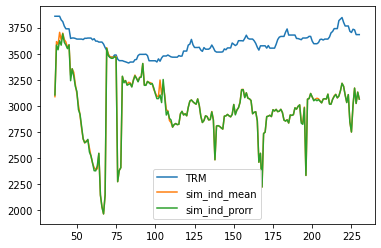

In [95]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion['sim_ind_mean'].notnull()][['TRM','sim_ind_mean','sim_ind_prorr']].plot()

In [96]:
comparacionIndiceVsSimulacion[:50]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
0,2020-09-09,2020-09-09,3757.21,NaN,NaN
1,2020-09-10,2020-09-10,3717.25,NaN,NaN
2,2020-09-11,2020-09-11,3700.28,NaN,NaN
3,2020-09-12,2020-09-12,3709.00,NaN,NaN
4,2020-09-13,2020-09-13,3709.00,NaN,NaN
5,2020-09-14,2020-09-14,3709.00,NaN,NaN
6,2020-09-15,2020-09-15,3697.00,NaN,NaN
7,2020-09-16,2020-09-16,3683.49,NaN,NaN
8,2020-09-17,2020-09-17,3703.86,NaN,NaN
9,2020-09-18,2020-09-18,3714.65,NaN,NaN


In [97]:
comparacionIndiceVsSimulacion[51:100]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
51,2020-11-15,2020-11-15,3639.95,3005.408911,2965.337874
52,2020-11-16,2020-11-16,3639.95,2910.635922,2920.941017
53,2020-11-17,2020-11-17,3639.95,2786.372223,2799.797717
54,2020-11-18,2020-11-18,3635.19,2683.872043,2685.324485
55,2020-11-19,2020-11-19,3647.73,2645.432611,2648.315795
56,2020-11-20,2020-11-20,3647.10,2666.276769,2657.340499
57,2020-11-21,2020-11-21,3649.90,2672.501075,2679.939365
58,2020-11-22,2020-11-22,3649.90,2595.314094,2558.775368
59,2020-11-23,2020-11-23,3649.90,2519.617175,2521.230308
60,2020-11-24,2020-11-24,3632.92,2450.960371,2454.437593


In [98]:
comparacionIndiceVsSimulacion[101:150]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
101,2021-01-05,2021-01-05,3420.78,3092.435773,3070.266546
102,2021-01-06,2021-01-06,3450.74,3090.715563,3070.455814
103,2021-01-07,2021-01-07,3428.04,3247.985791,3105.034560
104,2021-01-08,2021-01-08,3459.39,3111.472362,3032.318726
105,2021-01-10,2021-01-10,3478.11,3201.939762,3253.243259
106,2021-01-11,2021-01-11,3478.11,3100.316116,3081.544392
107,2021-01-12,2021-01-12,3478.11,2964.746243,2913.143178
108,2021-01-13,2021-01-13,3487.65,2952.589905,2948.237907
109,2021-01-14,2021-01-14,3478.36,2860.208616,2881.615681
110,2021-01-15,2021-01-15,3469.76,2840.592021,2865.697879


## 2.  buscar ley de potencia con tabla transacciones

In [99]:
DF_TRANSACCIONES_cop

,idComprador,idVendedor,cantidadTransaccion,precioTransaccion,fechaPulso,importe
0,729,424,1.068653e+04,1967.799629,36,2.102894e+07
1,345,424,5.490700e+04,1967.799629,36,1.080460e+08
2,704,521,2.436028e+05,2223.624910,36,5.416812e+08
3,759,521,5.626588e+04,2223.624910,36,1.251142e+08
4,850,521,4.177709e+03,2223.624910,36,9.289659e+06
...,...,...,...,...,...,...
39427,1624,1231,1.044607e+04,3065.604153,230,3.202351e+07
39428,1125,1231,1.818478e+04,3065.604153,230,5.574733e+07
39429,72,1231,3.199704e+05,3065.604153,230,9.809025e+08
39430,1042,1231,6.749232e+05,3065.604153,230,2.069047e+09


### Análisis Compradores

<AxesSubplot:>

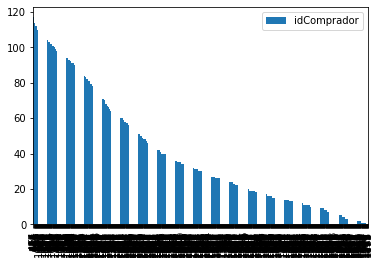

In [100]:
DF_TRANSACCIONES_cop['idComprador'].value_counts().to_frame().plot.bar()

<AxesSubplot:>

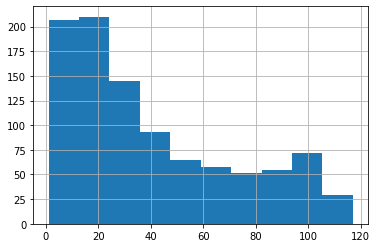

In [101]:
DF_TRANSACCIONES_cop['idComprador'].value_counts().hist()

<AxesSubplot:>

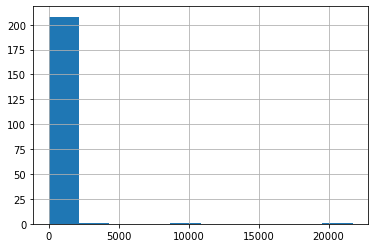

In [102]:
DF_TRANSACCIONES_cop['idVendedor'].value_counts().hist()

## Comportamiento Agentes específicos

In [103]:
df_estadoAgentes['id'].value_counts().to_frame('numTrans')

,numTrans
758,196
813,196
685,196
684,196
682,196
...,...
1634,1
1251,1
1247,1
1226,1


In [104]:
agente_longevo=df_estadoAgentes['id'].value_counts().to_frame('numTrans').index[0]
agente_longevo

758

In [105]:
#df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])]

In [106]:
df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])].set_index('pulso')

,id,TIPO,edad,capital,stockProducto,val_stock,val_empresa
pulso,,,,,,,
35,758,Comprador,0,5.545456e+08,690167.000000,2.663051e+09,1.476783e+18
36,758,Comprador,1,4.561551e+08,698529.167427,2.695317e+09,3.151472e+09
37,758,Comprador,2,3.748308e+08,707381.087998,2.185052e+09,2.559883e+09
38,758,Comprador,3,3.762229e+08,690113.810780,2.495313e+09,2.871536e+09
39,758,Comprador,4,3.188479e+08,691661.834329,2.481506e+09,2.800354e+09
...,...,...,...,...,...,...,...
226,758,Comprador,191,1.829906e+07,56636.401327,1.557726e+08,1.740716e+08
227,758,Comprador,192,1.708921e+07,56321.755764,1.692932e+08,1.863824e+08
228,758,Comprador,193,1.680440e+07,55892.295466,1.772245e+08,1.940289e+08


<AxesSubplot:xlabel='pulso'>

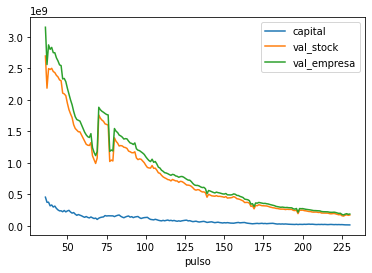

In [107]:
df_estadoAgentes[df_estadoAgentes['id'].isin([agente_longevo])].set_index('pulso')[['capital','val_stock','val_empresa']][1:].plot()

<AxesSubplot:xlabel='pulso'>

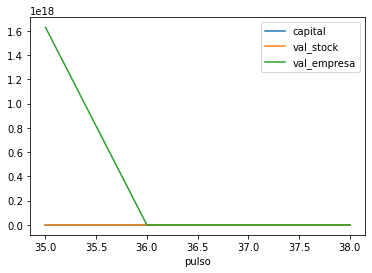

In [108]:
df_estadoAgentes[df_estadoAgentes['id'].isin([329])].set_index('pulso')[['capital','val_stock','val_empresa']].plot()

### Numero de transacciones por día

In [109]:
DF_TRANSACCIONES_cop['fechaPulso'].value_counts().to_frame('transDiarias').sort_index()

,transDiarias
36,234
37,287
38,285
39,264
40,255
...,...
226,149
227,147
228,149
229,147


<AxesSubplot:>

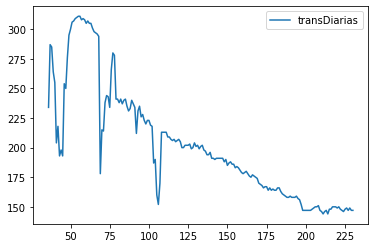

In [110]:
DF_TRANSACCIONES_cop['fechaPulso'].value_counts().to_frame('transDiarias').sort_index().plot()

In [111]:
## caracteristicas mejores agentes

In [112]:
## distribución mejores agentes en el tiempo

In [113]:
#exponente de hurst trm calculada

In [114]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO]

,Date,date,TRM,sim_ind_mean,sim_ind_prorr
37,2020-11-01,2020-11-01,3858.56,3615.798855,3583.020372
38,2020-11-02,2020-11-02,3858.56,3587.744276,3537.831667
39,2020-11-03,2020-11-03,3858.56,3704.461238,3624.430879
40,2020-11-04,2020-11-04,3823.45,3631.637224,3581.805898
41,2020-11-05,2020-11-05,3807.13,3696.967598,3690.059390
...,...,...,...,...,...
226,2021-05-13,2021-05-13,3734.09,3005.822517,3005.822517
227,2021-05-14,2021-05-14,3728.09,3170.821019,3170.821019
228,2021-05-15,2021-05-15,3682.84,3024.061191,3024.061191
229,2021-05-16,2021-05-16,3682.84,3132.253292,3132.253292


In [115]:
from hurst import compute_Hc

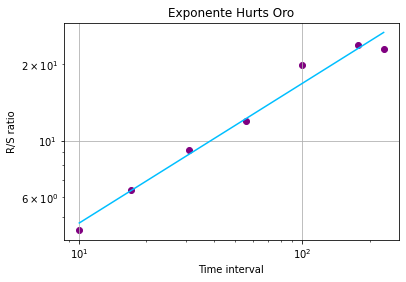

H=0.5491, c=1.3410


In [116]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion['TRM'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

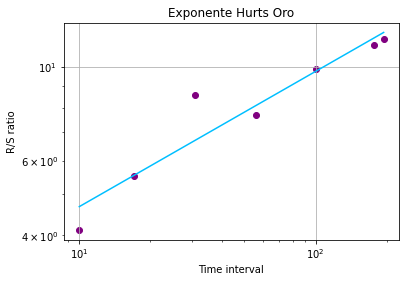

H=0.3188, c=2.2432


In [117]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO]['sim_ind_prorr'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [118]:
comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][-100:]['sim_ind_prorr']

131    2860.240667
132    2905.528692
133    2898.564677
134    2866.516075
135    2869.801397
          ...     
226    3005.822517
227    3170.821019
228    3024.061191
229    3132.253292
230    3065.604153
Name: sim_ind_prorr, Length: 100, dtype: float64

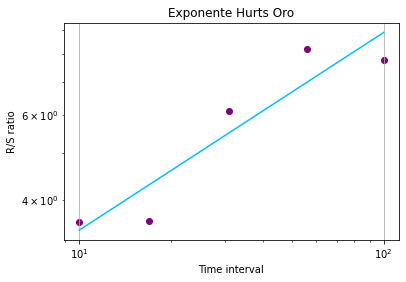

H=0.4090, c=1.3498


In [119]:
H, c, data = compute_Hc(comparacionIndiceVsSimulacion[comparacionIndiceVsSimulacion.index>FECHA_INICIAL_PULSO][-100:]['sim_ind_prorr'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

### 3 temas
* hacer un lazo cerrado para validar si mejora el exponente de hurst
* validar los puntos más bajos de pronóstico y validar como tratarlos
* mirar las lecturas de los mejores

# Repetir con mayor complejidad

In [120]:
252-FECHA_PULSO

21

In [121]:
#FECHA_INICIAL_PULSO=36
FECHA_PULSO=FECHA_INICIAL_PULSO 

In [122]:
VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']

In [123]:
#for generacion in range(0,100,1):
for generacion in range(0,len(calendario)-FECHA_INICIAL_PULSO,1):
    if tipo_indice=='real' or generacion==0:
        VALOR_MOMENTO_INDICE=datos_trm[datos_trm['date']<=calendario.iloc[FECHA_PULSO]['Date']].iloc[-1]['TRM']
    elif tipo_indice=='emergente':
        aux_df_transacciones=DF_TRANSACCIONES[DF_TRANSACCIONES['fechaPulso']==FECHA_PULSO-1]
        aux_df_transacciones['importe']=aux_df_transacciones['cantidadTransaccion']*aux_df_transacciones['precioTransaccion']
        #aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        VALOR_MOMENTO_INDICE=aux_df_transacciones['importe'].sum()/aux_df_transacciones['cantidadTransaccion'].sum()
        
    POBLACION_ACTUAL=len(compradores)+len(vendedores)    
    quiebraEmpresas()# capturar información de agentes quebrados
    POBLACION_ACTUAL=len(compradores)+len(vendedores)
    print("PULSO: ",FECHA_PULSO, "Generacion: ",generacion, " poblacion actual: ",POBLACION_ACTUAL,' numero acumulado agentes: ',NUMERO_ACUMULADO_AGENTES)
    nuevosAgentes()
    #print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores))
    pronosticoUniverso()
    compradoresActivos=[]
    vendedoresActivos=[]
    activacionUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    transaccionarUniverso()
    #print("numCompradoresActivos: ",len(compradoresActivos), "numVendedoresActivos: ",len(vendedoresActivos))
    vivirUniverso()
    print("numCompradores: ",len(compradores), "numVendedores: ",len(vendedores) )
    ## capturar estado empresas
    if len(compradores)>0:
        aux_df_agentC=pd.DataFrame.from_dict(compradores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentC['val_stock']=aux_df_agentC['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentC['val_empresa']=aux_df_agentC['val_stock']+aux_df_agentC['capital']
        aux_df_agentC['pulso']=FECHA_PULSO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentC)
        
    if len(vendedores)>0:
        aux_df_agentV=pd.DataFrame.from_dict(vendedores)[['id','TIPO','edad','capital','stockProducto']]
        aux_df_agentV['val_stock']=aux_df_agentV['stockProducto']*VALOR_MOMENTO_INDICE
        aux_df_agentV['val_empresa']=aux_df_agentV['val_stock']+aux_df_agentV['capital']
        aux_df_agentV['pulso']=FECHA_PULSO
        df_estadoAgentes=df_estadoAgentes.append(aux_df_agentV)
        
    FECHA_PULSO=FECHA_PULSO+1

PULSO:  36 Generacion:  0  poblacion actual:  298  numero acumulado agentes:  1687
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  298 pob final:  302
numCompradores:  298 numVendedores:  4
PULSO:  37 Generacion:  1  poblacion actual:  301  numero acumulado agentes:  1691
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  301 pob final:  304
numCompradores:  300 numVendedores:  4
PULSO:  38 Generacion:  2  poblacion actual:  301  numero acumulado agentes:  1694
max_generacion_agentes:  0.02 nuevos Agentes:  1 pob actual:  301 pob final:  302
numCompradores:  299 numVendedores:  3
PULSO:  39 Generacion:  3  poblacion actual:  300  numero acumulado agentes:  1695
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  300 pob final:  300
numCompradores:  298 numVendedores:  2
PULSO:  40 Generacion:  4  poblacion actual:  299  numero acumulado agentes:  1695
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  299 pob final:  299
numCompradores:  29

numCompradores:  288 numVendedores:  7
PULSO:  77 Generacion:  41  poblacion actual:  290  numero acumulado agentes:  1791
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  290 pob final:  294
numCompradores:  289 numVendedores:  5
PULSO:  78 Generacion:  42  poblacion actual:  291  numero acumulado agentes:  1795
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  291 pob final:  294
numCompradores:  290 numVendedores:  4
PULSO:  79 Generacion:  43  poblacion actual:  292  numero acumulado agentes:  1798
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  292 pob final:  292
numCompradores:  289 numVendedores:  3
PULSO:  80 Generacion:  44  poblacion actual:  289  numero acumulado agentes:  1798
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  289 pob final:  289
numCompradores:  287 numVendedores:  2
PULSO:  81 Generacion:  45  poblacion actual:  287  numero acumulado agentes:  1798
max_generacion_agentes:  0.02 nuevos Agentes:  2 pob actu

numCompradores:  290 numVendedores:  5
PULSO:  117 Generacion:  81  poblacion actual:  291  numero acumulado agentes:  1887
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  291 pob final:  295
numCompradores:  289 numVendedores:  6
PULSO:  118 Generacion:  82  poblacion actual:  291  numero acumulado agentes:  1891
max_generacion_agentes:  0.02 nuevos Agentes:  1 pob actual:  291 pob final:  292
numCompradores:  285 numVendedores:  7
PULSO:  119 Generacion:  83  poblacion actual:  289  numero acumulado agentes:  1892
max_generacion_agentes:  0.02 nuevos Agentes:  5 pob actual:  289 pob final:  294
numCompradores:  287 numVendedores:  7
PULSO:  120 Generacion:  84  poblacion actual:  291  numero acumulado agentes:  1897
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  291 pob final:  294
numCompradores:  285 numVendedores:  9
PULSO:  121 Generacion:  85  poblacion actual:  292  numero acumulado agentes:  1900
max_generacion_agentes:  0.02 nuevos Agentes:  5 pob

numCompradores:  283 numVendedores:  3
PULSO:  157 Generacion:  121  poblacion actual:  282  numero acumulado agentes:  1977
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  282 pob final:  285
numCompradores:  281 numVendedores:  4
PULSO:  158 Generacion:  122  poblacion actual:  284  numero acumulado agentes:  1980
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  284 pob final:  287
numCompradores:  282 numVendedores:  5
PULSO:  159 Generacion:  123  poblacion actual:  286  numero acumulado agentes:  1983
max_generacion_agentes:  0.02 nuevos Agentes:  0 pob actual:  286 pob final:  286
numCompradores:  282 numVendedores:  4
PULSO:  160 Generacion:  124  poblacion actual:  280  numero acumulado agentes:  1983
max_generacion_agentes:  0.02 nuevos Agentes:  2 pob actual:  280 pob final:  282
numCompradores:  279 numVendedores:  3
PULSO:  161 Generacion:  125  poblacion actual:  280  numero acumulado agentes:  1985
max_generacion_agentes:  0.02 nuevos Agentes:  

numCompradores:  266 numVendedores:  3
PULSO:  197 Generacion:  161  poblacion actual:  267  numero acumulado agentes:  2065
max_generacion_agentes:  0.02 nuevos Agentes:  4 pob actual:  267 pob final:  271
numCompradores:  267 numVendedores:  4
PULSO:  198 Generacion:  162  poblacion actual:  260  numero acumulado agentes:  2069
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  260 pob final:  263
numCompradores:  258 numVendedores:  5
PULSO:  199 Generacion:  163  poblacion actual:  262  numero acumulado agentes:  2072
max_generacion_agentes:  0.02 nuevos Agentes:  3 pob actual:  262 pob final:  265
numCompradores:  259 numVendedores:  6
PULSO:  200 Generacion:  164  poblacion actual:  262  numero acumulado agentes:  2075
max_generacion_agentes:  0.02 nuevos Agentes:  1 pob actual:  262 pob final:  263
numCompradores:  258 numVendedores:  5
PULSO:  201 Generacion:  165  poblacion actual:  258  numero acumulado agentes:  2076
max_generacion_agentes:  0.02 nuevos Agentes:  

In [135]:
DF_TRANSACCIONES_cop=DF_TRANSACCIONES.copy()
DF_TRANSACCIONES_cop['importe']=DF_TRANSACCIONES_cop['cantidadTransaccion']*DF_TRANSACCIONES_cop['precioTransaccion']
#DF_TRANSACCIONES_cop.index=DF_TRANSACCIONES_cop.index.astype(int)
DF_TRANSACCIONES_cop['idComprador']=DF_TRANSACCIONES_cop['idComprador'].astype(int)
DF_TRANSACCIONES_cop['idVendedor']=DF_TRANSACCIONES_cop['idVendedor'].astype(int)
DF_TRANSACCIONES_cop['fechaPulso']=DF_TRANSACCIONES_cop['fechaPulso'].astype(int)

In [136]:
indice_simulacion=DF_TRANSACCIONES_cop[['fechaPulso','precioTransaccion','cantidadTransaccion','importe']].groupby('fechaPulso').agg(['mean','sum'])
indice_simulacion

precioTransaccion               cantidadTransaccion                \
                        mean           sum                mean           sum   
fechaPulso                                                                     
36               3078.209637  1.126625e+06        8.127976e+04  2.974839e+07   
37               3397.307986  1.477829e+06        2.125570e+05  9.246228e+07   
38               3375.250082  1.461483e+06        1.070993e+05  4.637401e+07   
39               3414.597665  1.403400e+06        1.844443e+05  7.580661e+07   
40               3375.159498  1.356814e+06        2.755178e+05  1.107582e+08   
...                      ...           ...                 ...           ...   
226              2981.323445  8.198639e+05        7.959078e+06  2.188746e+09   
227              3130.229939  8.514225e+05        4.932945e+06  1.341761e+09   
228              3002.214911  8.226069e+05        1.232843e+06  3.377989e+08   
229              3099.566135  8.399824e+05        2.959414e+06  8.020013e+08   
230              3033.004013  8.249771e+05        9.433249e+06  2.565844e+09   

                 importe                
                    mean           sum  
fechaPulso                              
36          2.483114e+08  9.088195e+10  
37          6.874386e+08  2.990358e+11  
38          3.532745e+08  1.529678e+11  
39          5.934806e+08  2.439205e+11  
40          8.600083e+08  3.457233e+11  
...                  ...           ...  
226         2.390886e+10  6.574937e+12  
227         1.562269e+10  4.249372e+12  
228         3.710037e+09  1.016550e+12  
229         9.243562e+09  2.505005e+12  
230         2.889320e+10  7.858951e+12  

[195 rows x 6 columns]

In [137]:
indice_simulacion.columns = indice_simulacion.columns.map('|'.join).str.strip('|')
indice_simulacion['indiceProrr']=indice_simulacion['importe|sum']/indice_simulacion['cantidadTransaccion|sum']
indice_simulacion=indice_simulacion[['indiceProrr','precioTransaccion|mean']]
indice_simulacion

,indiceProrr,precioTransaccion|mean
fechaPulso,,
36,3055.020724,3078.209637
37,3234.138274,3397.307986
38,3298.568598,3375.250082
39,3217.668632,3414.597665
40,3121.425105,3375.159498
...,...,...
226,3003.973966,2981.323445
227,3167.011357,3130.229939
228,3009.335343,3002.214911


In [138]:
indice_simulacion.columns=['sim_ind_mean','sim_ind_prorr']

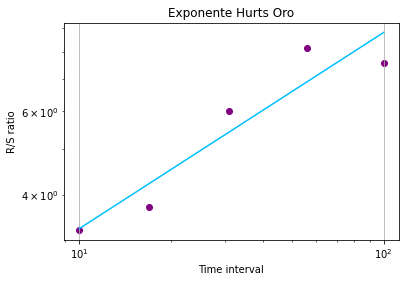

H=0.4130, c=1.3118


In [141]:
H, c, data = compute_Hc(indice_simulacion[-100:]['sim_ind_prorr'], kind='price', simplified=True)
# Plot
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.set_title('Exponente Hurts Oro')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

#### Validar cantidad de lecturas por día

In [124]:
datos_lectura

,fuente,date,polaridad,index,tipo
0,BluRadioCo,2020-10-09,-0.347026,118,twitter
1,BluRadioCo,2020-10-10,-0.271511,118,twitter
2,BluRadioCo,2020-10-11,-0.635847,118,twitter
3,BluRadioCo,2020-10-25,-0.249044,118,twitter
4,BluRadioCo,2020-10-26,-0.410109,118,twitter
...,...,...,...,...,...
78606,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.719400,117,rss
78607,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.960484,117,rss
78608,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.977641,117,rss
78609,https://www.reforma.com/rss/portada.xml,2021-05-05,-0.882855,117,rss


In [125]:
rango_lectura

['2020-10-09', '2021-05-18']

In [126]:
#datos_lectura['date','polaridad']
datos_lectura[['date','polaridad']].groupby('date').agg(['mean','count'])

polaridad      
                mean count
date                      
2020-10-09 -0.343185    18
2020-10-10 -0.322106   427
2020-10-11 -0.209762   725
2020-10-12 -0.280221   789
2020-10-13 -0.110029    10
...              ...   ...
2021-05-14 -0.287004   485
2021-05-15 -0.369271   232
2021-05-16 -0.265847   310
2021-05-17 -0.164764   362
2021-05-18 -0.433676    22

[222 rows x 2 columns]

<AxesSubplot:xlabel='date'>

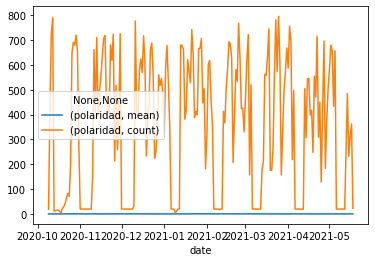

In [127]:
datos_lectura[['date','polaridad']].groupby('date').agg(['mean','count']).plot()

In [128]:
1-Junio  5-dic

SyntaxError: invalid syntax (<ipython-input-128-848bfbffe351>, line 1)